In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.datasets import make_regression, load_diabetes
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import scipy.stats as stats

from sklearn.base import BaseEstimator, RegressorMixin

# <center> Linear Regression from scratch </center>

In [291]:
class CustomLinearRegression(BaseEstimator, RegressorMixin):  # BaseEstimator inheritance: Makes it compatible with sklearn pipelines. Specifically, for learning curve method to work
    def __init__(self, number_of_iterations=1000, learning_rate=0.1, regularize=False, regularization_strength=0.1, verbose=False, log_every=100, tolerance = 0.001):
        self.weights : np.ndarray = None  # (n_features, )
        self.bias : float = None  # scalar
        self.number_of_iterations : int = number_of_iterations
        self.learning_rate : float = learning_rate
        self.regularize = regularize
        self.regularization_strength = regularization_strength
        self.final_cost : float = 0.0
        self.cost_history : list[float] = []
        self.verbose : bool = verbose
        self.log_every : int = log_every
        self.tolerance : float = tolerance

    def _init_parameters(self, number_of_features):
        self.weights = np.random.uniform(-0.01, 0.01, number_of_features)
        self.bias = 0

    def _compute_loss(self, y, y_hat) -> float:
        error = y - y_hat
        mean_squared_error = np.mean(error ** 2)

        if self.regularize:
            l2 = self.regularization_strength * np.sum(self.weights ** 2)
            return 1/2 * (mean_squared_error + l2)
        
        return 1/2 * mean_squared_error
    
    def _forward_propagation(self, X, y):
        y_hat = X @ self.weights + self.bias
        cost = self._compute_loss(y, y_hat)
        self.cost_history.append(cost)
        return y_hat, cost
    
    def _backward_propagation(self, X, y, y_hat):
        number_of_samples = X.shape[0]
        error = y_hat - y

        bias_derivative = np.mean(error)

        # weights gradient without regulariztion
        weights_gradient = 1 / number_of_samples * (X.T @ error)

        # add L2 regularization if enabled
        if self.regularize:
            weights_gradient += self.regularization_strength * self.weights
        
        return weights_gradient, bias_derivative
    
    def _update(self, weights_gradient, bias_derivative):
        self.weights = self.weights - self.learning_rate * weights_gradient
        self.bias = self.bias - self.learning_rate * bias_derivative

    def fit(self, X, y):
        self._init_parameters(X.shape[1])
        previous_cost = np.inf

        for iteration in range(self.number_of_iterations):
            y_hat, cost = self._forward_propagation(X, y)
            
            if self.verbose == True and abs(previous_cost - cost) < self.tolerance:
                print(f'Early stopping at iteration: {iteration} due to ΔCost being less {self.tolerance}')
                break

            if self.verbose and (iteration % self.log_every == 0 or iteration == self.number_of_iterations - 1):
                print(f'Iteration: {iteration} | Cost: {cost:.5f} | Weights Norm: {np.linalg.norm(self.weights)}')
            
            previous_cost = cost
            weights_derivative, bias_derivative = self._backward_propagation(X, y, y_hat)
            self._update(weights_derivative, bias_derivative)

 
        self.final_cost = cost
        return self

    def predict(self, X):
        predictions = X @ self.weights + self.bias
        return predictions
    
    def get_parameters(self):
        return self.weights, self.bias
    
    def plot_losses(self, ax=None):
        if ax is None:
            ax = plt.gca()
        
        sns.lineplot(self.cost_history, label=f'Final cost: {self.final_cost:.5f}', ax=ax)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Cost')
        ax.set_title('Training Cost Vs Iteration')
        ax.grid()
        ax.legend()

    # Not a useful plot unless data is a time series

    # @staticmethod
    # def plot_residuals(residuals, ax=None):
    #     if ax is None:
    #         ax = plt.gca()

    #     ax.scatter(x=np.arange(len(residuals)), y=residuals, alpha=0.7)
    #     ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
        
    #     ax.set_xlabel('X axis')
    #     ax.set_ylabel('Residuals')
    #     ax.set_title('Residuals plot')
    #     ax.grid()

    @staticmethod
    def plot_residuals_histogram(residuals, bins=20, ax=None):
        '''
            1. A good residuals model should be centered around 0
                If residuals aren't centered around 0, it means your model has systematic bias
                Meaning that the model is consistently over-predicting or under-predicting
                This violates the assumption that E(residuals) = 0
            2. Linear regression assumes errors are normally distributed: ε ~ N(0, σ²)
                If residuals ARE normal:
                    Your model is missing randomness only - the patterns you haven't captured are just noise
                    The unexplained variation behaves like pure random error
                    Your model has captured the systematic relationships in the data
                If residuals are NOT normal:
                    Your model is missing systematic patterns - there are still discoverable relationships you haven't captured
                    The errors aren't just random noise - they have structure
            3. Possible residuals that are not good are:
                a. Skewed residuals: Model systematically worse for high/low values
                b. Heavy tails: Model occasionally makes huge mistakes (outliers)
                c. Bimodal: Model works differently for different groups in your data
        '''
        if ax is None:
            ax = plt.gca()

        sns.histplot(residuals, kde=True, bins=bins, alpha=0.7, ax=ax)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

        ax.set_xlabel('Residuals')
        ax.set_title('Residuals histogram')
        ax.grid()
    
    @staticmethod
    def plot_residuals_vs_predictions(predictions, residuals, ax=None):
        '''
            A good residuals vs predictions plot should be a random scatter, with not discernible shape around y = 0 line
            The spread of residuals should be constant across all predicted values.
            If there's an expanding or contracting residuals shape as predictions values increase, this indicates non-constant variance.
            This violates the Homoscedasticity(constant variance) assumption of linear regression.
            Systematic patterns in the scatter plot (curve, smiles, frowns), indicates that there exists a nonlinear relationship between
                the features and target. This violates the Linearity assumption(features should be have a linear relationship with the target)
                This indicates that linear regression is not a good model for the dataset.
            If the average residual is not close to zero, this indicates the existence of systematic bias in the predictions.
                If most residuals are under zero, the model tends to under predict. If most residuals are above zero, the model tends to over predict.

            Used to detect:
                Heteroscedasticity: residual spread changes with predicted value.
                Nonlinearity: curve or pattern suggests missing nonlinear component.
                Bias: residuals systematically above or below 0.
        '''
        if ax is None:
            ax = plt.gca()

        sns.scatterplot(x=predictions, y=residuals, alpha=0.7, ax=ax)
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
        
        ax.set_xlabel('Predictions')
        ax.set_ylabel('Residuals')
        ax.set_title('Residuals vs Predictions')
        ax.grid()

    @staticmethod
    def plot_predictions_vs_true(true_values, predictions, ax=None):
        '''
            A good true values vs predictions plot should show a tight scatter around the diagonal line.
            This indicates that our predictions are very close to the true value (indicated by the diagonal line)
            The tighter the clustering of the scatters around the diagonal, the better our model is.
            Also, the higher R2 score, the tighter the clustering of the scatters around the diagonal is.

            Used to detect:
                Bias: whether the model is systematically over or under predicting and at which range of values (low true values or high ones)
        '''
        if ax is None:
            ax = plt.gca()

        sns.scatterplot(x=true_values, y=predictions, alpha=0.7, ax=ax)
        
        # Reference line y = x
        min_val = min(true_values.min(), predictions.min())
        max_val = max(true_values.max(), predictions.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

        ax.set_xlabel('True values')
        ax.set_ylabel('Predictions')
        ax.set_title('Predictions vs true plot')
        ax.grid()

    # def __repr__(self):
    #     return (f"CustomLinearRegression(iterations={self.number_of_iterations},\n"
    #             f"lr={self.learning_rate}, regularize={self.regularize},\n"
    #             f"reg_strength={self.regularization_strength})")
    
    @staticmethod
    def plot_qq(residuals, ax=None):
        """
            Generate a Q-Q plot for the given residuals.

            Parameters:
            residuals (array-like): The residuals to plot.

                        | What You See                  | What It Means                                                              |
            | ----------------------------- | -------------------------------------------------------------------------- |
            | Points lie on a straight line | Your data is well-modeled by the chosen distribution (often normal)        |
            | S-curve shape                 | Your data has **heavier or lighter tails** than the reference distribution |
            | Upward curve at the ends      | Your data has **heavy tails** (outliers in both directions)                |
            | Downward curve at the ends    | Your data has **light tails** (less spread than normal)                    |
            | Asymmetry in curve            | Indicates **skewness** (left or right skew)                                |

        """
        if ax is None:
            ax = plt.gca()

        stats.probplot(residuals, dist="norm", plot=ax)
        ax.set_title("Q-Q Plot of Residuals")
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Sample Quantiles")
        ax.grid()


        ### This is not important to learn.
        ### It only serves to match the colors of other plots. Not important at all
        # Change scatter points color
        for line in ax.get_lines():
            # line[0] is usually points, line[1] is the 45-degree line
            line.set_color('#1f77b4')
            line.set_markersize(5)
            line.set_alpha(1)
        # Change line color (if needed)
        # Usually the last line is the fit line:
        ax.get_lines()[-1].set_color('red')
        ax.get_lines()[-1].set_linestyle('--')
        ax.get_lines()[-1].set_linewidth(2)

---

# <center> Evalute the model on synthetic data </center>

Iteration: 0 | Cost: 6923.73151 | Weights Norm: 0.011412981814066834
Iteration: 500 | Cost: 1216.25578 | Weights Norm: 106.9649736028689
Early stopping at iteration: 592 due to ΔCost being less 0.001


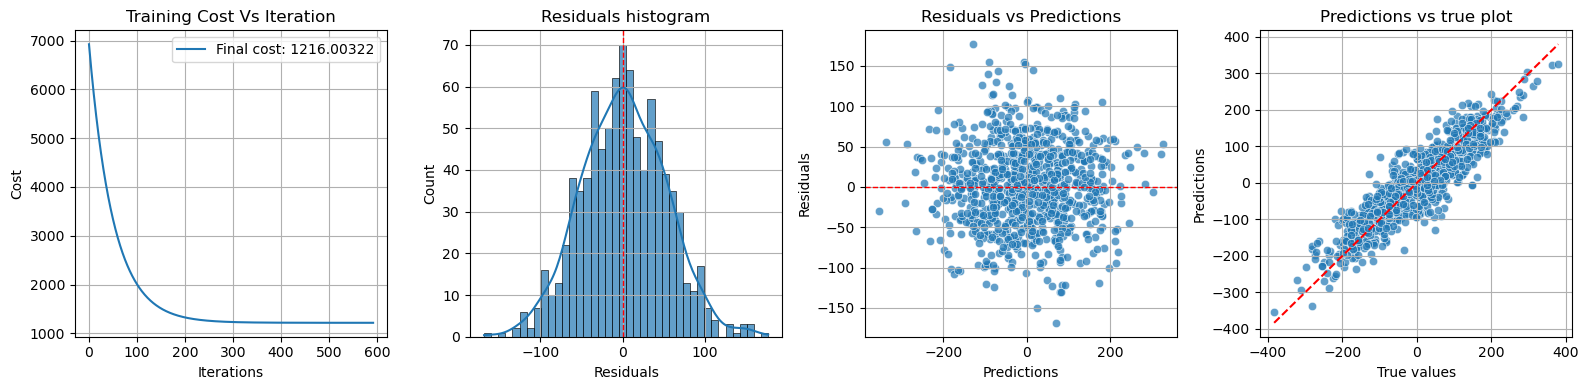

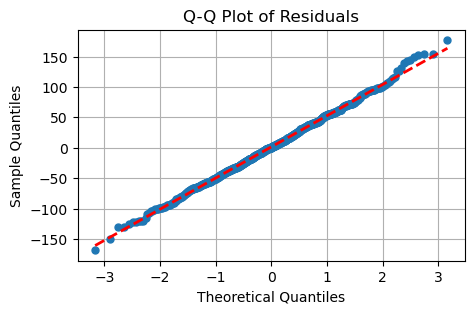

In [ ]:
# Generate synthetic data
features_synthetic, target_synthetic = make_regression(n_samples=3000, n_features=3, noise=50, random_state=42)


# Split the data
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic  = train_test_split(features_synthetic, target_synthetic, test_size=0.3, random_state=100, shuffle=True)


# Initialize the model, fit it, then predict
lr_custom = CustomLinearRegression(verbose=True, learning_rate=0.01, number_of_iterations=10000, log_every=500).fit(X_train_synthetic, y_train_synthetic)
predictions = lr_custom.predict(X_test_synthetic)


# plot the evaluation plots
figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

lr_custom.plot_losses(ax=axes[0])
CustomLinearRegression.plot_residuals_histogram(y_test_synthetic - predictions, ax=axes[1])
CustomLinearRegression.plot_residuals_vs_predictions(predictions, y_test_synthetic - predictions, ax=axes[2])
CustomLinearRegression.plot_predictions_vs_true(y_test_synthetic,  predictions, ax=axes[3])

figure.tight_layout()


plt.figure(figsize=(5, 3))
CustomLinearRegression.plot_qq(y_test_synthetic - predictions)

---

# <center> The diabetes dataset </center>

In [266]:

data = load_diabetes(as_frame=True)

features = data.data
target = data.target

print(data.DESCR)
print('-'*100)
print(features.shape)
print(target.shape)
print('-'*100)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [267]:
features.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038,0.051,0.062,0.022,-0.044,-0.035,-0.043,-0.003,0.020,-0.018
1,-0.002,-0.045,-0.051,-0.026,-0.008,-0.019,0.074,-0.039,-0.068,-0.092
2,0.085,0.051,0.044,-0.006,-0.046,-0.034,-0.032,-0.003,0.003,-0.026
3,-0.089,-0.045,-0.012,-0.037,0.012,0.025,-0.036,0.034,0.023,-0.009
4,0.005,-0.045,-0.036,0.022,0.004,0.016,0.008,-0.003,-0.032,-0.047


In [268]:
print(features.isnull().sum(axis=0))

pd.set_option('display.float_format', '{:.3f}'.format)

features.describe()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000
mean,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000
std,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048
min,-0.107,-0.045,-0.090,-0.112,-0.127,-0.116,-0.102,-0.076,-0.126,-0.138
25%,-0.037,-0.045,-0.034,-0.037,-0.034,-0.030,-0.035,-0.039,-0.033,-0.033
50%,0.005,-0.045,-0.007,-0.006,-0.004,-0.004,-0.007,-0.003,-0.002,-0.001
75%,0.038,0.051,0.031,0.036,0.028,0.030,0.029,0.034,0.032,0.028
max,0.111,0.051,0.171,0.132,0.154,0.199,0.181,0.185,0.134,0.136


<Axes: >

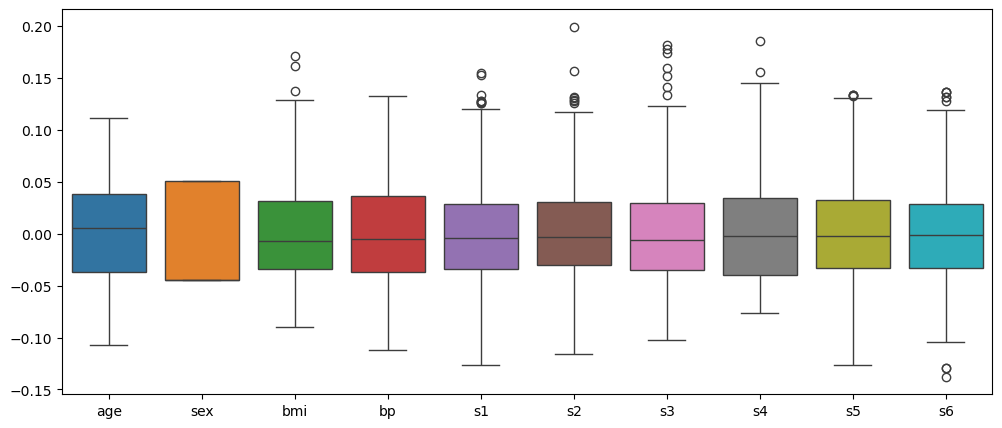

In [269]:

plt.figure(figsize=(12, 5))
sns.boxplot(features.select_dtypes('number'))

---

# <center> Compare the custom linear regression class with other models </center>

In [270]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test  = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=True)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# The custom Linear Regression class
lr_custom = CustomLinearRegression(
                                    number_of_iterations=5000, learning_rate=0.05,
                                    regularize=True, regularization_strength=0.1).fit(X_train, y_train)
predictions_custom = lr_custom.predict(X_test)


# Standard Linear Regression as a base model 
lr_ols = LinearRegression().fit(X_train, y_train)
predictions_base = lr_ols.predict(X_test)

# Ridge Regression
ridge = Ridge(alpha=5).fit(X_train, y_train)
predictions_ridge = ridge.predict(X_test)

In [271]:
# Mean Squared Errors
mse_custom = mean_squared_error(y_test, predictions_custom)
mse_ols = mean_squared_error(y_test, predictions_base)
mse_ridge = mean_squared_error(y_test, predictions_ridge)

# --------------------------------------------------------------------------------------------------------

#  R2 scores
r2_custom = r2_score(y_test, predictions_custom)
r2_ols = r2_score(y_test, predictions_base)
r2_ridge = r2_score(y_test, predictions_ridge)


# --------------------------------------------------------------------------------------------------------

# Mean Absolute Value scores
mae_custom = mean_absolute_error(y_test, predictions_custom)
mae_ols = mean_absolute_error(y_test, predictions_base)
mae_ridge = mean_absolute_error(y_test, predictions_ridge)


In [272]:
mse_scores = [mse_custom, mse_ols, mse_ridge]
r2_scores = [r2_custom, r2_ols, r2_ridge]
mae_scores = [mae_custom, mae_ols, mae_ridge]
labels = ['Custom', 'OLS', 'Ridge']

print(pd.DataFrame(index=labels, data={'MSE scores': mse_scores, 'R2 scores': r2_scores, 'MAE scores': mae_scores}))

        MSE scores  R2 scores  MAE scores
Custom    2807.962      0.480      41.837
OLS       2821.751      0.477      41.919
Ridge     2819.486      0.478      41.856


---

# <center> Evaluation plots for all models </center>

### &emsp; Calculate residuals

In [273]:
residuals_custom = y_test - predictions_custom
residuals_ols = y_test - predictions_base
residuals_ridge = y_test - predictions_ridge

### &emsp; Plot 

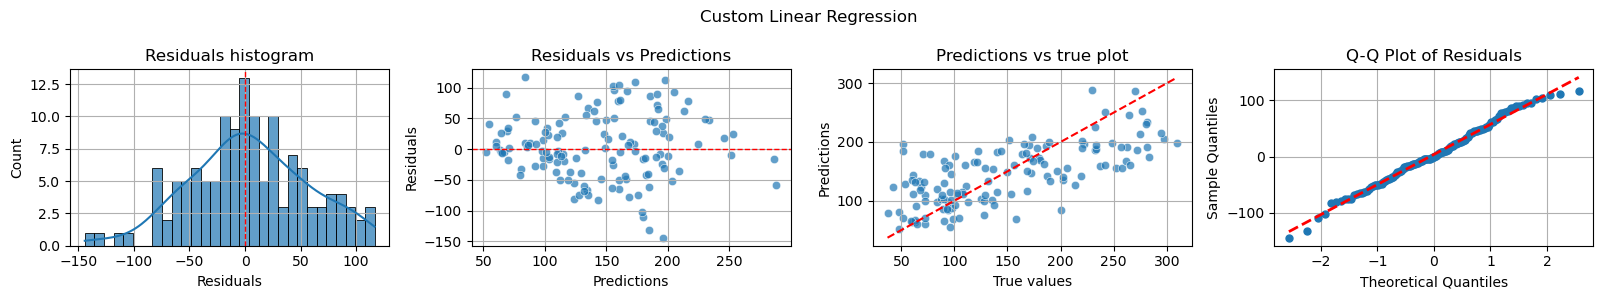

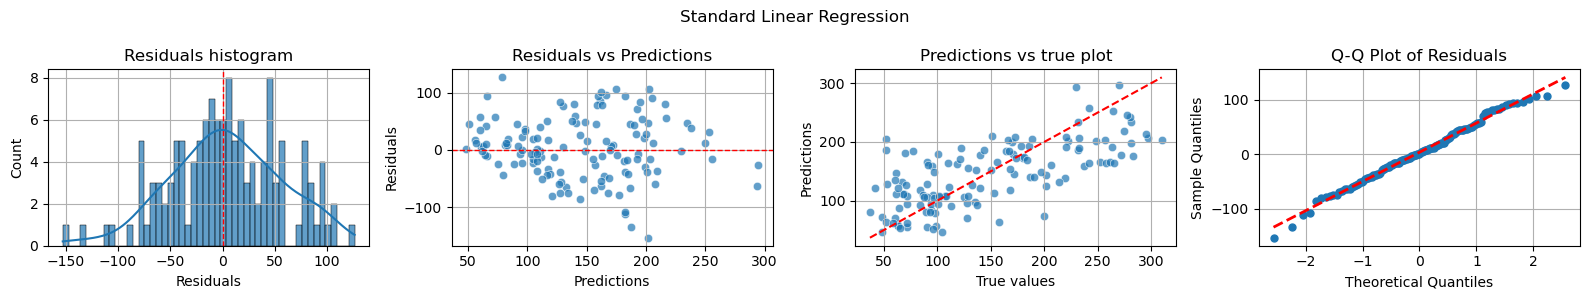

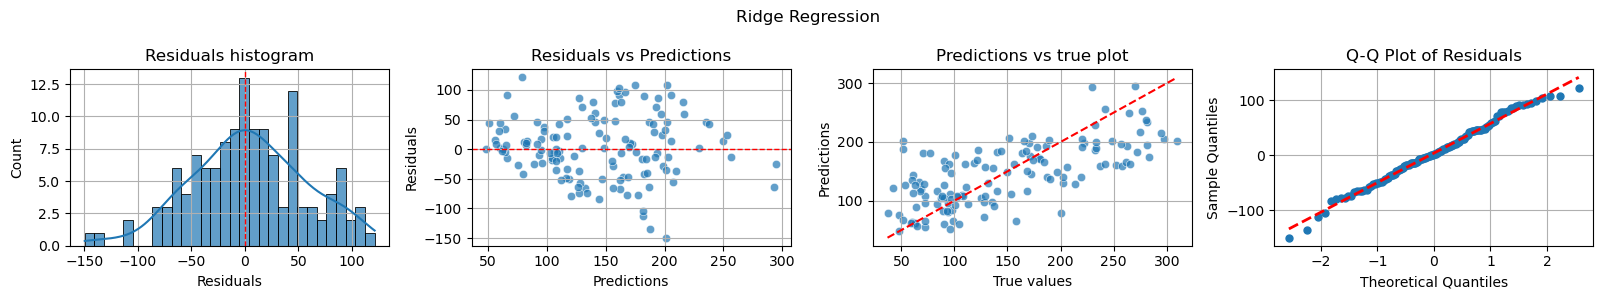

In [295]:
# CustomLinearRegression plots

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
figure.suptitle('Custom Linear Regression')

CustomLinearRegression.plot_residuals_histogram(residuals_custom, bins=30, ax=axes[0])
CustomLinearRegression.plot_residuals_vs_predictions(predictions_custom, residuals_custom, ax=axes[1])
CustomLinearRegression.plot_predictions_vs_true(y_test, predictions_custom, ax=axes[2])
CustomLinearRegression.plot_qq(residuals_custom, ax=axes[3])

figure.tight_layout()

# --------------------------------------------------------------------------------------------------------

# Standard linear regression plots

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
figure.suptitle('Standard Linear Regression')

CustomLinearRegression.plot_residuals_histogram(residuals_ols, bins=50, ax=axes[0])
CustomLinearRegression.plot_residuals_vs_predictions(predictions_ridge, residuals_ols, ax=axes[1])
CustomLinearRegression.plot_predictions_vs_true(y_test, predictions_base, ax=axes[2])
CustomLinearRegression.plot_qq(residuals_ols, ax=axes[3])

figure.tight_layout()

# --------------------------------------------------------------------------------------------------------

# Ridge regression plots

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
figure.suptitle('Ridge Regression')

CustomLinearRegression.plot_residuals_histogram(residuals_ridge, bins=30, ax=axes[0])
CustomLinearRegression.plot_residuals_vs_predictions(predictions_ridge, residuals_ridge, ax=axes[1])
CustomLinearRegression.plot_predictions_vs_true(y_test, predictions_ridge, ax=axes[2])
CustomLinearRegression.plot_qq(residuals_ridge, ax=axes[3])

figure.tight_layout()

---

# <center> Learning Curve </center>

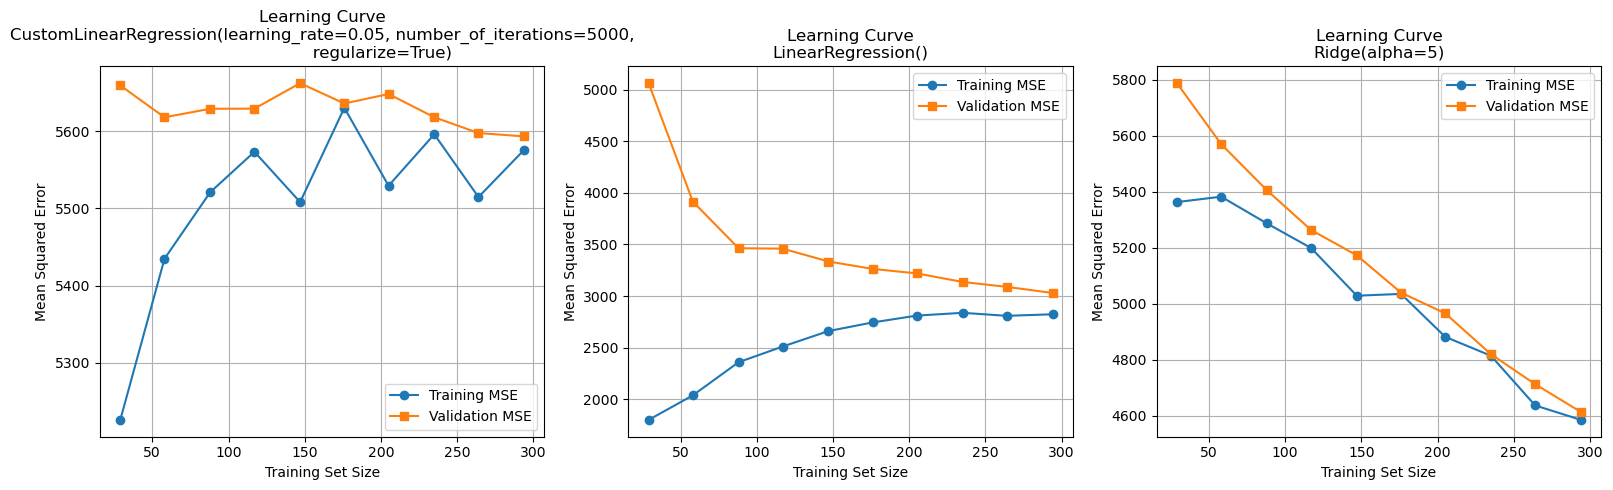

In [275]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=3, scoring='neg_mean_squared_error', ax=None):
    '''
        Plots a learning curve showing training and validation errors 
        (Mean Squared Error) as a function of training set size.

        Parameters
        ----------
        model : estimator object
            The machine learning model that implements the scikit-learn fit/predict interface.

        X : array-like of shape (n_samples, n_features)
            Feature matrix.

        y : array-like of shape (n_samples,)
            Target vector.

        train_sizes : array-like of shape (n_ticks,), default=np.linspace(0.1, 1.0, 10)
            Relative or absolute numbers of training examples that will be used 
            to generate the learning curve. Values should be between 0 and 1 
            if float, representing a fraction of the training data.

        cv : int, cross-validation generator or an iterable, default=3
            Determines the cross-validation splitting strategy. Passed directly 
            to `sklearn.model_selection.learning_curve`.

        scoring : str or callable, default='neg_mean_squared_error'
            A scoring strategy, compatible with scikit-learn's scoring options. 
            Default uses negative MSE for regression.

        ax : matplotlib Axes object, default=None
            The axes on which to plot. If None, a new one will be created using `plt.gca()`.

        Returns
        -------
        None
            The function modifies the provided Axes object in place to display the learning curve.

        Notes
        -----
        - Converts negative MSE to positive before plotting.
        - Uses cross-validation to compute mean training and validation errors.
        - Random shuffling is applied before splitting the data to improve robustness.
    '''
    if ax is None:
        ax = plt.gca()

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        shuffle=True,
        random_state=42,
        n_jobs=-1,
    )
    
    # Convert negative MSE to positive
    train_errors = -np.mean(train_scores, axis=1)
    val_errors = -np.mean(val_scores, axis=1)

    ax.plot(train_sizes, train_errors, label='Training MSE', marker='o')
    ax.plot(train_sizes, val_errors, label='Validation MSE', marker='s')
    ax.set_title(f'Learning Curve\n{str(model)}')
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Mean Squared Error')
    ax.legend()
    ax.grid()


figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

plot_learning_curve(lr_custom, features, target, ax=axes[0])
plot_learning_curve(lr_ols, features, target, ax=axes[1])
plot_learning_curve(ridge, features, target, ax=axes[2])

figure.tight_layout()

---
---
---

# <center> KFold </center>

In [276]:
from sklearn.model_selection import KFold

def kfold( X, y, model_class, n_splits=5, **model_kwargs):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = (X.iloc[train_index], X.iloc[val_index]) if isinstance(X, pd.DataFrame) else (X[train_index], X[val_index])
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = model_class(**model_kwargs).fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)

    mean_mse_score = np.mean(mse_scores)
    baseline_mse = np.mean((y - y.mean())**2)  # or just variance of y
    mse_change_percent  = np.round( (baseline_mse - mean_mse_score) / baseline_mse * 100,  0)

    mean_r2_score = np.mean(r2_scores)

    print(f"\nOn average, across all folds, the variance in the validation data that the model explains is: {mean_r2_score * 100:.2f}%")
    print(f"Compared to naively just predicting the mean, the model's mean squared error changed by: {mse_change_percent:.0f}%.\n")

    return mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores
# learning_rate=0.01, regularize=False, regularization_strength=0.001,
#                                    verbose=False, number_of_iterations=5000,
#                                    log_every=500
n_splits = 5

lr_custom_params = {'learning_rate': 0.005, 'regularize': True, 'regularization_strength': 1, 'verbose': True}
mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores = kfold(X_train, y_train, n_splits=n_splits, **lr_custom_params,model_class=CustomLinearRegression)

svr_params = {'kernel':'linear', 'C':1}
mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores = kfold(X_test, y_test, n_splits=n_splits, **svr_params,
                                                                             model_class=SVR)

Iteration: 0 | Cost: 14952.73015 | Weights Norm: 0.017795649300393027
Iteration: 100 | Cost: 6347.91671 | Weights Norm: 20.42293446715131
Iteration: 200 | Cost: 3581.59127 | Weights Norm: 23.673851466423013
Iteration: 300 | Cost: 2572.16218 | Weights Norm: 24.568098445894403
Iteration: 400 | Cost: 2200.77537 | Weights Norm: 24.881238231932823
Iteration: 500 | Cost: 2063.83676 | Weights Norm: 25.003014951710018
Iteration: 600 | Cost: 2013.29935 | Weights Norm: 25.054546649771446
Iteration: 700 | Cost: 1994.64021 | Weights Norm: 25.078319472905843
Iteration: 800 | Cost: 1987.74917 | Weights Norm: 25.09021995412241
Iteration: 900 | Cost: 1985.20376 | Weights Norm: 25.096591634864726
Iteration: 999 | Cost: 1984.26891 | Weights Norm: 25.100146602919615
Iteration: 0 | Cost: 15397.69117 | Weights Norm: 0.017123326932688632
Iteration: 100 | Cost: 6564.84191 | Weights Norm: 20.193696134783355
Iteration: 200 | Cost: 3679.76114 | Weights Norm: 23.754763898513676
Iteration: 300 | Cost: 2631.29411 

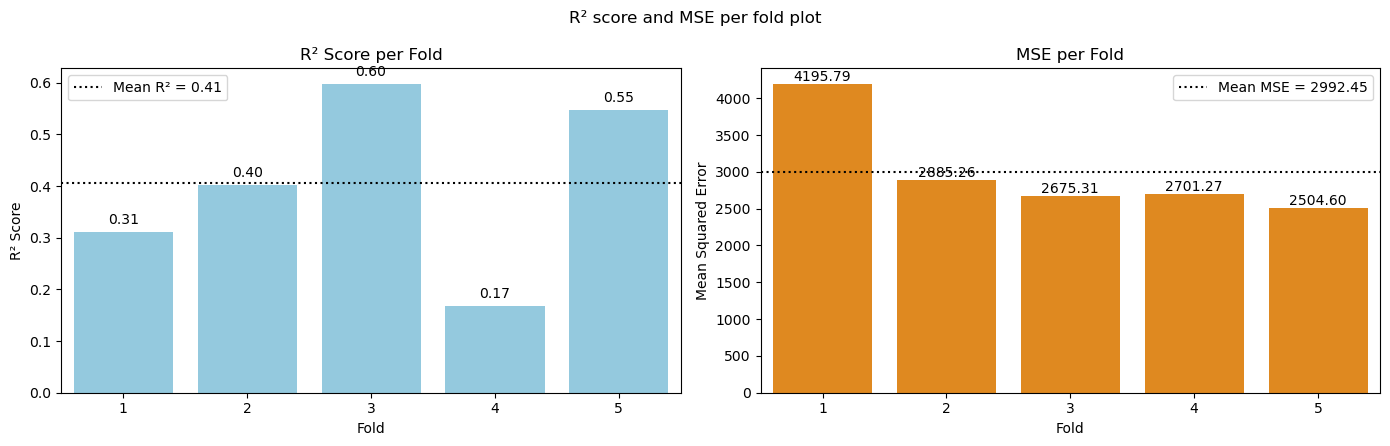

In [277]:
    # --- Plotting ---
figure, axes = plt.subplots(1, 2, figsize=(14, 4.5))

# R2 plot
bar_r2 = sns.barplot(y=r2_scores, x=list(range(1, n_splits + 1)), ax=axes[0], color="skyblue")
axes[0].set_title('R² Score per Fold')
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('Fold')
axes[0].axhline(mean_r2_score, linestyle='dotted', color='black', label=f'Mean R² = {mean_r2_score:.2f}')
axes[0].legend()
for i, score in enumerate(r2_scores):
    axes[0].text(i, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10)


# MSE plot
sns.barplot(y=mse_scores, x=list(range(1, n_splits + 1)), ax=axes[1], color="darkorange")
axes[1].set_title('MSE per Fold')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_xlabel('Fold')
axes[1].axhline(y=mean_mse_score, linestyle='dotted', color='black', label=f'Mean MSE = {mean_mse_score:.2f}')
axes[1].legend()
for i, score in enumerate(mse_scores):
    axes[1].text(i, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10)


figure.suptitle('R² score and MSE per fold plot')
figure.tight_layout()
plt.show()